In [253]:
%load_ext autoreload
%autoreload 2
from utils import *
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
twitter_db = connect_to_db()

In [242]:
N = 10000
cursor = twitter_db.cursor()

query = ("SELECT t1.user_id, t1.in_reply_to_user_id, t1.quoted_user_id, t1.retweeted_user_id \
        FROM tweets t1\
        WHERE lang='fr' AND \
        ((NOT (t1.text LIKE '%RT @%')) OR \
        (t1.text LIKE '%RT @%' AND \
            EXISTS \
                (SELECT * \
                FROM tweets t2 \
                WHERE t2.user_id = t1.user_id AND NOT (t2.text LIKE '%RT @%')\
                )\
        )\
        )\
        LIMIT " + str(N))

cursor.execute(query)

In [243]:
G_dict = dict()

for (user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id) in cursor:
    #print(user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id)
    if user_id not in G_dict:
        G_dict[user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        
    if not(in_reply_to_user_id is None):
        if in_reply_to_user_id not in G_dict:
            G_dict[in_reply_to_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if in_reply_to_user_id not in G_dict[user_id]['replied_to']:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] = 1
        else:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] += 1
            
    if not(quoted_user_id is None):
        if quoted_user_id not in G_dict:
            G_dict[quoted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if quoted_user_id not in G_dict[user_id]['quoted']:
            G_dict[user_id]['quoted'][quoted_user_id] = 1
        else:
            G_dict[user_id]['quoted'][quoted_user_id] += 1
    
    if not(retweeted_user_id is None):
        if retweeted_user_id not in G_dict:
            G_dict[retweeted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if retweeted_user_id not in G_dict[user_id]['retweeted']:
            G_dict[user_id]['retweeted'][retweeted_user_id] = 1
        else:
            G_dict[user_id]['retweeted'][retweeted_user_id] += 1
    
cursor.close()       

True

In [244]:
G = nx.DiGraph()
G.add_nodes_from(G_dict.keys())

for (u1,v) in G_dict.items():
    for (u2, count) in v['quoted'].items():
        #print("quoted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='quoted',weight=count)
    for (u2, count) in v['replied_to'].items():
        #print("replied to : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='replied_to',weight=count)
    for (u2, count) in v['retweeted'].items():
        #print("retweeted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='retweeted',weight=count)

In [245]:
G_undirected = nx.Graph(G)

In [246]:
partition = community.best_partition(G_undirected)

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


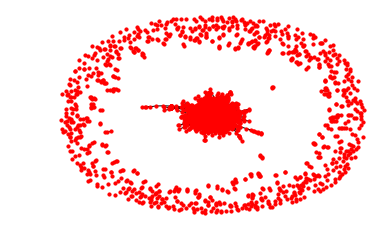

In [247]:
spring_pos = nx.spring_layout(G_undirected)
plt.axis('off')
nx.draw_networkx(G_undirected, pos=spring_pos, with_labels=False, node_size=10)

In [248]:
parts = community.best_partition(G_undirected)
values = [parts.get(node) for node in G_undirected.nodes()]

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


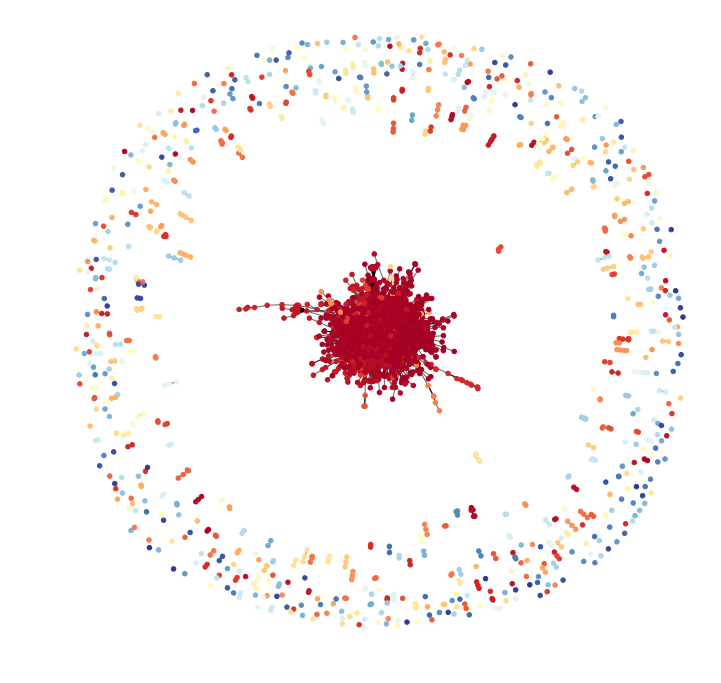

In [249]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_undirected, spring_pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=values)
nx.draw_networkx_edges(G_undirected, spring_pos, alpha=0.6)
plt.axis('off')
plt.show(G_undirected)

In [266]:
len(np.unique(values))

705

In [268]:
c = Counter(values)

In [270]:
sorted(np.unique(values), key=c.get, reverse=True)[:3]

[7, 3, 2]

In [274]:
len(parts)

5028

In [277]:
users_7 = []

In [278]:
for user_id, group in parts.items():
    if group == 7:
        users_7.append(user_id)

In [283]:
users_7 = tuple(users_7)

In [288]:
twitter_db = connect_to_db()
cursor = twitter_db.cursor()

query = ("SELECT text \
        FROM tweets\
        WHERE lang='fr' AND \
        user_id IN " + str(users_7) + " OR \
        in_reply_to_user_id IN " + str(users_7) + " OR \
        quoted_user_id IN " + str(users_7) + " OR \
        retweeted_user_id IN " + str(users_7))

cursor.execute(query)

In [289]:
tweets_7 = []
for tweet in cursor:
    tweets_7.append(tweet)
cursor.close()

In [290]:
cursor.close()

True

In [291]:
tweets_7

[('RT @ULYSSE888: #Macron: "Il n\'y a pas de culture française."\n#Mélenchon: "Nous ne descendons pas des Gaulois."\n#Hamon: "Je suis fier qu\'on…',),
 ("RT @PrisonPlanet: Macron's solution to France's terrorism problem is to spy on your Skype chats &amp; keep letting terrorists into France. http…",),
 ("Les seuls à se rendre compte du prob st Fillon et Le Pen.Mais l'un est un démocrate,l'autre non.",),
 ('RT @FloPortelli: Appel de 31 entrepreneurs, investisseurs et acteurs du numérique à voter pour @FrancoisFillon : https://t.co/z1K5yu3sgm vi…',),
 ("RT @PrisonPlanet: Hollande privately telling establishment Macron is his choice.\n\nMacron's numbers drop as his fake populist act is exposed…",),
 ("RT @Valeurs: L'appel du pied culotté de Copé à Fillon &gt;&gt; https://t.co/Ci1uOD6vAH https://t.co/djLNac623V",),
 ('RT @Fil__Urbain: La persévérance et la force de FILLON sont la preuve de sa capacité à présider !!\nBRAVO FILLON POUR TA FORCE !\n#Fillon2017…',),
 ('RT @RidiculeTV: En jean 